# Reference implementation comparison performance data generation

We need to generate data comparing performance of the reference implementation of HDBSCANthe accelerated Python library. We wish to do this varying over dataset size so we can get an idea of scaling, and we also need to consider data set dimension sizes. We'll need some handy modules: sklearn.datasets to generate fake data for clustering; numpy and pandas for easy manipulation of vectors and dataframes of results; and subprocess and time so we can actually fork off and time the actual Java refeence implementation. Finally we'll make use of os.path to check if we have already computed the data and simply reload it rather than embark on an expensive computation.

In [1]:
import sklearn.datasets
import numpy as np
import pandas as pd
import subprocess
import time
import os.path

Now we need a function to actually time the reference implementation. We can do external timing using the time module, and the Java program also returns internal timings, which we can parse out and save to a dataframe. In practice this is just a matter of using subprocess an the appropriate commandline parameters for the reference code. Note that due to interpretational differences (on how less than or equal to is handled) we use "different" ``min_points`` and ``min_cluster_size`` parameters than the Python library (which defaults using 5 for both). In practice the two implementations are performing the equivalent clustering.

In [2]:
def get_reference_timings(data, filename='tmp_data.csv', 
                          jarfile='/Users/leland/Source/HDBSCAN_Star/HDBSCAN_Star.jar',
                          min_points=6, min_cluster_size=4):
    
    # Create the required csv file
    pd.DataFrame(data).to_csv('tmp_data.csv', header=False, index=False)
    
    # Run the clustering via a subprocess call and grab the output as it
    # has timing information to be parsed
    start_time = time.time()
    internal_timing = subprocess.check_output(['java', '-jar', jarfile,
                                               'file={}'.format(filename),
                                               'minPts={}'.format(min_points),
                                               'minClSize={}'.format(min_cluster_size),
                                               'compact=true'])
    time_taken = time.time() - start_time
    internal_timing = internal_timing.decode('UTF-8')
    
    # Parse internal timing info into a pandas series for later use
    result_dict = {}
    for line in internal_timing.split('\n'):
        if ':' in line:
            key, value = line.split(':')
            key = key.replace(' (ms)', '')
            key = key.replace('Time to ', '')
            key = key.replace('Overall ', '')
            value = int(value)
            result_dict[key] = value
            
    internal_timing = pd.Series(result_dict)
    
    return time_taken, internal_timing

With that in hand we can run the code over a range of dimensions and dataset sizes and aggregate the results together in indexed pandas series or dataframes.

In [3]:
if not os.path.isfile('reference_impl_external_timings.csv'):
    internal_timing = {}
    external_timing = {}

    for dataset_dimension in (2,50):
        for dataset_size in np.arange(1,21) * 10000:
            data, _ = sklearn.datasets.make_blobs(dataset_size, 
                                                  n_features=dataset_dimension, 
                                                  centers=dataset_dimension)
            (external_timing[(dataset_dimension, dataset_size)], 
             internal_timing[(dataset_dimension, dataset_size)]) = get_reference_timings(data)

            print('Completed dimension {} and dataset size {}'.format(
                                                dataset_dimension, dataset_size))

    internal_timing_df = pd.DataFrame(internal_timing).T
    external_timing_series = pd.Series(external_timing)
else:
    internal_timing_df = pd.read_csv('reference_impl_internal_timings.csv', 
                                     index_col=(0,1))
    external_timing_series = pd.read_csv('reference_impl_external_timings.csv', 
                  index_col=(0,1), 
                  header=None,
                  names=('','',2))[2]

Now it is just a matter of saving these off to disk for later use.

In [4]:
if not os.path.isfile('reference_impl_internal_timings.csv'):
    internal_timing_df.to_csv('reference_impl_internal_timings.csv')
if not os.path.isfile('reference_impl_external_timings.csv'):
    external_timing_series.to_csv('reference_impl_external_timings.csv')

Now we need to gather timings for the accelerated Python implementation. This is slightly more straightforward as getting timing data on the Python code is easier than passing out to Java. As before we reload previously saved data if we have already computed the relevant data. 

In [5]:
import hdbscan

In [7]:
if not os.path.isfile('hdbscan_to_reference_timings.csv'):
    hdbscan_timings = {}

    for dataset_dimension in (2,50):
        for dataset_size in np.arange(1,21) * 10000:
            data, _ = sklearn.datasets.make_blobs(dataset_size, 
                                                  n_features=dataset_dimension, 
                                                  centers=dataset_dimension)
            start_time = time.time()
            hdbscan.HDBSCAN().fit(data)
            time_taken = time.time() - start_time
            hdbscan_timings[(dataset_dimension, dataset_size)] = time_taken
            print('Completed dimension {} and dataset size {}'.format(
                                                dataset_dimension, dataset_size))


    hdbscan_timings_series = pd.Series(hdbscan_timings).T
    hdbscan_timings_series.to_csv('hdbscan_to_reference_timings.csv')
else:
    hdbscan_timings_series = pd.read_csv('hdbscan_to_reference_timings.csv', 
                                         index_col=(0,1), 
                                         names=('', '', 2))[2]

Now we simply need to generate the relevant plot. In practice this involves some finessing on matplotlib to get exactly the plot rendering I desire.

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
%matplotlib inline
sns.set_context('poster')

In [11]:
hdbscan_timing_df = hdbscan_timings_series.reset_index(1)
hdbscan_timing_df.columns = ['x', 'y']
external_timing_df = external_timing_series.reset_index(1)
external_timing_df.columns = ['x', 'y']

Now we simply make the plots in a grid, with both normal and logscales. Note that seaborn's ``regplot`` requires the actual log-log data to perform the regression fit correctly, so we use that, and then finesse the ticks and labels to provide the log scale. 

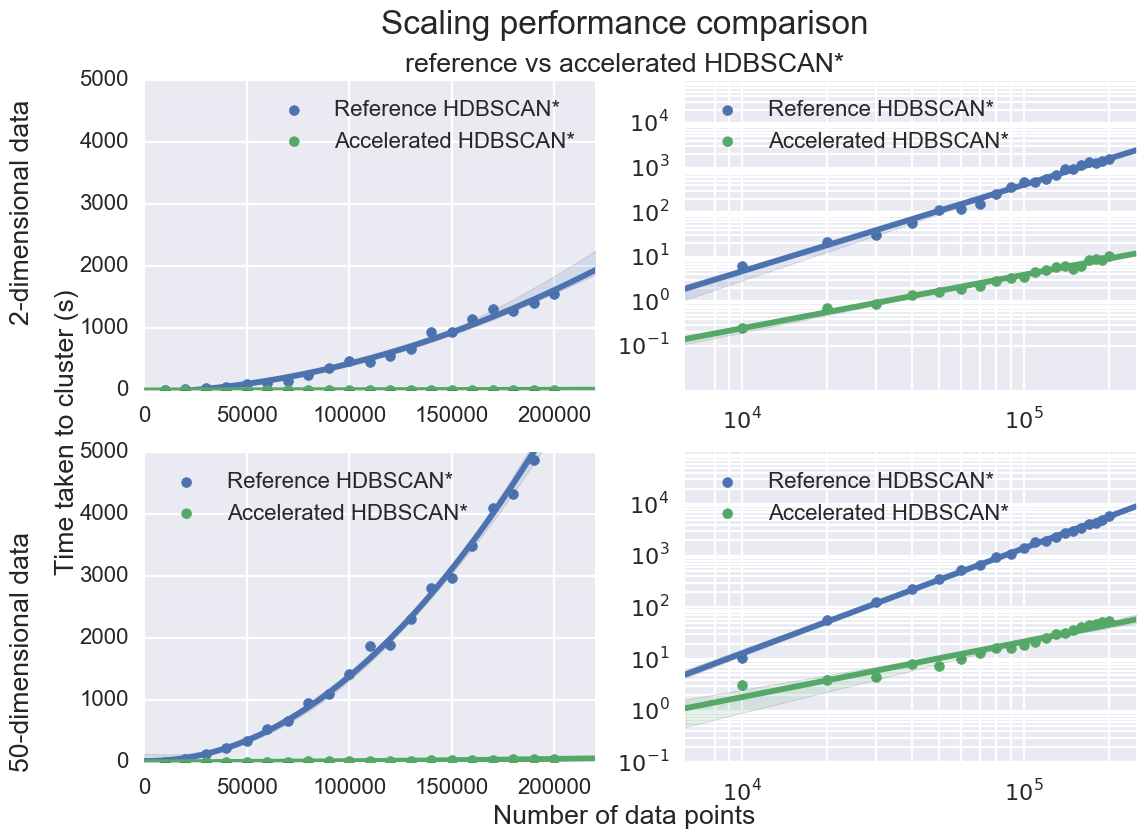

In [12]:
fig = plt.figure()
ax = fig.add_subplot(221)
ax.axis([0, 220000, 0, 5000])
sns.regplot(x='x', y='y', 
            data=external_timing_df.loc[2], 
            label='Reference HDBSCAN*',
            order=2,
            x_estimator=np.mean,
            ax=ax)
sns.regplot(x='x', y='y', 
            data=hdbscan_timings_df.loc[2],  
            label='Accelerated HDBSCAN*',
            order=2,
            x_estimator=np.mean,
            ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
plt.legend(loc='best')

ax = fig.add_subplot(222)
xticks = np.log10(np.hstack([
    np.arange(8000, 10000, 1000),
    np.arange(10000,100000,10000), 
    np.arange(100000,300000,100000)]))
xtick_labels = ["", "", "$10^4$"] + [""]*8 + ["$10^5$"]
yticks = np.log10(np.hstack([
    np.arange(0.1, 1, 0.1),
    np.arange(1, 10, 1),
    np.arange(10,100,10),
    np.arange(100,1000,100),
    np.arange(1000, 10000, 1000),
    np.arange(10000, 100000, 10000)
]))
ytick_labels = ["$10^{-1}$"] + [""]*8 + ["$10^0$"] +\
                [""]*8 + ["$10^1$"] + [""]*8 + ["$10^2$"] +\
                [""]*8 + ["$10^3$"] + [""]*8 + ["$10^4$"] +\
                [""]*8 + ["$10^5$"]
sns.regplot(x='x', y='y', 
            data=np.log10(external_timing_df.loc[2]), 
            label='Reference HDBSCAN*', 
            x_estimator=np.mean,
            ax=ax)
sns.regplot(x='x', y='y', 
            data=np.log10(hdbscan_timings_df.loc[2]),  
            label='Accelerated HDBSCAN*', 
            x_estimator=np.mean,
            ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)
ax.legend(loc='best')


ax = fig.add_subplot(223)
ax.axis([0, 220000, 0, 5000])
sns.regplot(x='x', y='y', 
            data=external_timing_df.loc[50], 
            label='Reference HDBSCAN*',
            order=2,
            x_estimator=np.mean,
            ax=ax)
sns.regplot(x='x', y='y', 
            data=hdbscan_timings_df.loc[50],  
            label='Accelerated HDBSCAN*',
            order=2,
            x_estimator=np.mean,
            ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
plt.legend(loc='best')
ax = fig.add_subplot(224)
xticks = np.log10(np.hstack([
    np.arange(8000, 10000, 1000),
    np.arange(10000,100000,10000), 
    np.arange(100000,300000,100000)]))
xtick_labels = ["", "", "$10^4$"] + [""]*8 + ["$10^5$"]
yticks = np.log10(np.hstack([
    np.arange(0.1, 1, 0.1),
    np.arange(1, 10, 1),
    np.arange(10,100,10),
    np.arange(100,1000,100),
    np.arange(1000, 10000, 1000),
    np.arange(10000, 100000, 10000)
]))
ytick_labels = ["$10^{-1}$"] + [""]*8 + ["$10^0$"] +\
                [""]*8 + ["$10^1$"] + [""]*8 + ["$10^2$"] +\
                [""]*8 + ["$10^3$"] + [""]*8 + ["$10^4$"] +\
                [""]*8 + ["$10^5$"]
sns.regplot(x='x', y='y', 
            data=np.log10(external_timing_df.loc[50]), 
            label='Reference HDBSCAN*', 
            x_estimator=np.mean,
            ax=ax)
sns.regplot(x='x', y='y', 
            data=np.log10(hdbscan_timings_df.loc[50]),  
            label='Accelerated HDBSCAN*', 
            x_estimator=np.mean,
            ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)
ax.legend(loc='best')

fig.text(0.5, 0.055, 'Number of data points', ha='center')
fig.text(0.055, 0.5, 'Time taken to cluster (s)', va='center', rotation='vertical')
fig.text(0.02, 0.75, '2-dimensional data', va='center', rotation='vertical')
fig.text(0.02, 0.25, '50-dimensional data', va='center', rotation='vertical')

fig.suptitle('Scaling performance comparison', fontsize=24)
fig.text(0.5, 0.91, 'reference vs accelerated HDBSCAN*', ha='center')
#plt.tight_layout()

plt.savefig('reference_comparison.png')